# 1.13d: Token Cloud Geometry

**Goal:** Analyze bulk geometric properties of the token embedding cloud.

## Method

Memory-efficient analysis of:
1. **Centroid and spread**: Where is the center? How dispersed?
2. **Norm distribution**: Are tokens clustered at a specific radius?
3. **Per-dimension statistics**: Is each dimension centered? Gaussian?
4. **PCA**: What are the principal directions of variation?
5. **1D projections**: Histogram along key axes
6. **Sampled distances**: Distance distribution without full pairwise matrix
7. **Nearest neighbors**: Local density analysis

## Design Principles

- **Scalable**: Works for Qwen (151k tokens × 2560D)
- **Memory-efficient**: No large pairwise matrices (batch processing)
- **Comparative**: Easy to run on W₀, W₅₀₀₀, W₁₀₀₀₀ to track evolution

## Parameters

Flexible tensor loading for any model/timestep.

## Parameters

In [1]:
# Tensor to analyze
TENSOR_FILE = "../tensors/Lil_Gatsby/1.12a_training_data.safetensors"
TENSOR_KEY = "W"
TENSOR_INDEX = 0  # -1 = final, 0 = init, None = no indexing

# Optional: Live/dead token masks (for Lil Gatsby)
LIVE_TOKENS_PATH = "../tensors/Lil_Gatsby/1.11b_live_tokens.safetensors"
DEAD_TOKENS_PATH = "../tensors/Lil_Gatsby/1.11b_dead_tokens.safetensors"
USE_TOKEN_MASKS = True  # Set to False for other models

# Analysis parameters
N_DISTANCE_SAMPLES = 10000  # How many random pairs for distance sampling
K_NEAREST_NEIGHBORS = 10    # How many nearest neighbors to find per token
N_PCA_COMPONENTS = 3        # Number of principal components to compute
RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats

## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
# Load W matrix
data = load_file(TENSOR_FILE)
W = data[TENSOR_KEY]

if TENSOR_INDEX is not None:
    W = W[TENSOR_INDEX]
    index_desc = f"index {TENSOR_INDEX}"
else:
    index_desc = "(no indexing)"

# Convert to float32 for analysis
W = W.to(torch.float32)

n_vectors, n_dims = W.shape

print(f"✓ Loaded W matrix from {Path(TENSOR_FILE).name}")
print(f"  Key: {TENSOR_KEY}")
print(f"  Index: {index_desc}")
print(f"  Shape: {W.shape}")
print(f"  Analyzing {n_vectors:,} tokens in {n_dims:,} dimensions")

# Load token masks if available
if USE_TOKEN_MASKS and Path(LIVE_TOKENS_PATH).exists():
    live_data = load_file(LIVE_TOKENS_PATH)
    dead_data = load_file(DEAD_TOKENS_PATH)
    
    live_tokens = live_data['token_ids'].to(torch.int64)
    dead_tokens = dead_data['token_ids'].to(torch.int64)
    
    print(f"\n✓ Loaded token masks")
    print(f"  Live tokens: {len(live_tokens)}")
    print(f"  Dead tokens: {len(dead_tokens)}")
    
    has_masks = True
else:
    has_masks = False
    print(f"\n(No token masks loaded)")

✓ Loaded W matrix from 1.12a_training_data.safetensors
  Key: W
  Index: index 0
  Shape: torch.Size([128, 64])
  Analyzing 128 tokens in 64 dimensions

✓ Loaded token masks
  Live tokens: 76
  Dead tokens: 52


## 1. Centroid and Spread

In [5]:
print("\n" + "=" * 80)
print("CENTROID AND SPREAD")
print("=" * 80)
print()

# Compute centroid (mean)
centroid = W.mean(dim=0)

# Distance from origin
centroid_norm = torch.norm(centroid).item()

print(f"Centroid:")
print(f"  Norm (distance from origin): {centroid_norm:.6f}")
print(f"  First 10 components: {centroid[:10].tolist()}")
print()

# Compute spread (std per dimension)
std_per_dim = W.std(dim=0)
mean_std = std_per_dim.mean().item()

print(f"Spread (standard deviation per dimension):")
print(f"  Mean std across dimensions: {mean_std:.6f}")
print(f"  Min std: {std_per_dim.min().item():.6f}")
print(f"  Max std: {std_per_dim.max().item():.6f}")
print()

# Test if centered at origin (t-test)
# H0: mean = 0 in each dimension
t_stats = centroid / (std_per_dim / np.sqrt(n_vectors))
n_significant = (t_stats.abs() > 2).sum().item()  # |t| > 2 ≈ p < 0.05

print(f"Centering test (is mean significantly different from zero?):")
print(f"  Dimensions with |t| > 2: {n_significant}/{n_dims} ({100*n_significant/n_dims:.1f}%)")
if n_significant < n_dims * 0.1:
    print(f"  ✓ Cloud appears centered near origin")
else:
    print(f"  ⚠️  Cloud is offset from origin")
print()


CENTROID AND SPREAD

Centroid:
  Norm (distance from origin): 0.013697
  First 10 components: [-0.0014089904725551605, 0.0005652792751789093, 0.0018445681780576706, 0.0008293315768241882, 0.0006460323929786682, 0.0017540976405143738, -0.002982407808303833, 0.0018125867936760187, 0.0008639134466648102, 0.0009839832782745361]

Spread (standard deviation per dimension):
  Mean std across dimensions: 0.019927
  Min std: 0.017294
  Max std: 0.023061

Centering test (is mean significantly different from zero?):
  Dimensions with |t| > 2: 3/64 (4.7%)
  ✓ Cloud appears centered near origin



## 2. Norm Distribution

In [6]:
print("\n" + "=" * 80)
print("NORM DISTRIBUTION")
print("=" * 80)
print()

# Compute norms
norms = torch.norm(W, dim=1)

print(f"Norm statistics (L2 distance from origin):")
print(f"  Mean:   {norms.mean().item():.6f}")
print(f"  Std:    {norms.std().item():.6f}")
print(f"  Min:    {norms.min().item():.6f}")
print(f"  Max:    {norms.max().item():.6f}")
print(f"  Median: {norms.median().item():.6f}")
print()

# Compare live vs dead if available
if has_masks:
    norms_live = norms[live_tokens]
    norms_dead = norms[dead_tokens]
    
    print(f"Comparison (live vs. dead tokens):")
    print(f"  Live mean: {norms_live.mean().item():.6f}")
    print(f"  Dead mean: {norms_dead.mean().item():.6f}")
    print(f"  Difference: {(norms_live.mean() - norms_dead.mean()).item():.6f}")
    
    # t-test
    t_stat, p_value = stats.ttest_ind(norms_live.numpy(), norms_dead.numpy())
    print(f"  t-test: t={t_stat:.3f}, p={p_value:.6f}")
    if p_value < 0.05:
        print(f"  ⚠️  Significant difference in norms")
    else:
        print(f"  ✓ No significant difference")
    print()


NORM DISTRIBUTION

Norm statistics (L2 distance from origin):
  Mean:   0.158937
  Std:    0.014880
  Min:    0.122482
  Max:    0.200465
  Median: 0.159193

Comparison (live vs. dead tokens):
  Live mean: 0.158804
  Dead mean: 0.159132
  Difference: -0.000329
  t-test: t=-0.122, p=0.902927
  ✓ No significant difference



## 3. Per-Dimension Statistics

In [7]:
print("\n" + "=" * 80)
print("PER-DIMENSION STATISTICS")
print("=" * 80)
print()

# Compute statistics for each dimension
means = W.mean(dim=0)
stds = W.std(dim=0)
mins = W.min(dim=0)[0]
maxs = W.max(dim=0)[0]

print(f"Dimension statistics (averaged over {n_dims} dimensions):")
print(f"  Mean of means: {means.mean().item():.6f}")
print(f"  Mean of stds:  {stds.mean().item():.6f}")
print()

# Check for dimensions with unusual properties
# Low variance = "dead" dimension
low_var_threshold = stds.median() * 0.1
low_var_dims = (stds < low_var_threshold).sum().item()

print(f"Dimension variance analysis:")
print(f"  Median std: {stds.median().item():.6f}")
print(f"  Dimensions with std < 10% of median: {low_var_dims}")
if low_var_dims > 0:
    print(f"  ⚠️  Some dimensions have very low variance (near-constant)")
else:
    print(f"  ✓ All dimensions show reasonable variance")
print()

# Show most/least variable dimensions
sorted_stds, sorted_indices = stds.sort(descending=True)
print(f"Most variable dimensions:")
for i in range(min(5, n_dims)):
    dim = sorted_indices[i].item()
    std = sorted_stds[i].item()
    print(f"  Dimension {dim:3d}: std = {std:.6f}")

print(f"\nLeast variable dimensions:")
for i in range(max(0, n_dims-5), n_dims):
    dim = sorted_indices[i].item()
    std = sorted_stds[i].item()
    print(f"  Dimension {dim:3d}: std = {std:.6f}")
print()


PER-DIMENSION STATISTICS

Dimension statistics (averaged over 64 dimensions):
  Mean of means: 0.000067
  Mean of stds:  0.019927

Dimension variance analysis:
  Median std: 0.019542
  Dimensions with std < 10% of median: 0
  ✓ All dimensions show reasonable variance

Most variable dimensions:
  Dimension  51: std = 0.023061
  Dimension   9: std = 0.022826
  Dimension  61: std = 0.021898
  Dimension  18: std = 0.021806
  Dimension  43: std = 0.021783

Least variable dimensions:
  Dimension  10: std = 0.018733
  Dimension  22: std = 0.018657
  Dimension  32: std = 0.018599
  Dimension  41: std = 0.017938
  Dimension  62: std = 0.017294



## 4. PCA (Principal Component Analysis)

In [8]:
print("\n" + "=" * 80)
print("PRINCIPAL COMPONENT ANALYSIS")
print("=" * 80)
print()

# Center the data
W_centered = W - centroid

# Compute PCA
pca = PCA(n_components=N_PCA_COMPONENTS)
W_pca = pca.fit_transform(W_centered.numpy())

print(f"Computed {N_PCA_COMPONENTS} principal components\n")

print(f"Explained variance:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {100*var:.2f}% of variance")

cumulative_var = pca.explained_variance_ratio_.sum()
print(f"  Total: {100*cumulative_var:.2f}% explained by top {N_PCA_COMPONENTS} components")
print()

# Store for later visualization
W_pca_torch = torch.tensor(W_pca, dtype=torch.float32)


PRINCIPAL COMPONENT ANALYSIS

Computed 3 principal components

Explained variance:
  PC1: 4.36% of variance
  PC2: 4.12% of variance
  PC3: 4.07% of variance
  Total: 12.55% explained by top 3 components



## 5. 1D Projections

In [9]:
print("\n" + "=" * 80)
print("1D PROJECTION ANALYSIS")
print("=" * 80)
print()

# Test dimension 0 (arbitrary choice)
dim_to_test = 0
values_dim0 = W[:, dim_to_test]

print(f"Dimension {dim_to_test} projection:")
print(f"  Mean: {values_dim0.mean().item():.6f}")
print(f"  Std:  {values_dim0.std().item():.6f}")
print(f"  Min:  {values_dim0.min().item():.6f}")
print(f"  Max:  {values_dim0.max().item():.6f}")

# Test normality (Shapiro-Wilk test)
if n_vectors <= 5000:  # Shapiro-Wilk has sample size limits
    stat, p_value = stats.shapiro(values_dim0.numpy())
    print(f"  Normality test (Shapiro-Wilk): p={p_value:.4f}")
    if p_value < 0.05:
        print(f"    ⚠️  Significantly non-Gaussian")
    else:
        print(f"    ✓ Consistent with Gaussian")
print()

# Test PC1 (most important direction)
values_pc1 = W_pca_torch[:, 0]

print(f"PC1 projection:")
print(f"  Mean: {values_pc1.mean().item():.6f}")
print(f"  Std:  {values_pc1.std().item():.6f}")
print(f"  Min:  {values_pc1.min().item():.6f}")
print(f"  Max:  {values_pc1.max().item():.6f}")
print()


1D PROJECTION ANALYSIS

Dimension 0 projection:
  Mean: -0.001409
  Std:  0.019266
  Min:  -0.057129
  Max:  0.047363
  Normality test (Shapiro-Wilk): p=0.9160
    ✓ Consistent with Gaussian

PC1 projection:
  Mean: -0.000000
  Std:  0.033349
  Min:  -0.097010
  Max:  0.102654



## 6. Sampled Distance Distribution

In [10]:
print("\n" + "=" * 80)
print("SAMPLED DISTANCE DISTRIBUTION")
print("=" * 80)
print()

# Sample random pairs
torch.manual_seed(RANDOM_SEED)
n_samples = min(N_DISTANCE_SAMPLES, n_vectors * (n_vectors - 1) // 2)

indices_i = torch.randint(0, n_vectors, (n_samples,))
indices_j = torch.randint(0, n_vectors, (n_samples,))

# Ensure i != j
mask = indices_i != indices_j
indices_i = indices_i[mask][:n_samples]
indices_j = indices_j[mask][:n_samples]

# Compute distances
distances = torch.norm(W[indices_i] - W[indices_j], dim=1)

print(f"Sampled {len(distances):,} random pairwise distances\n")

print(f"Distance statistics:")
print(f"  Mean:   {distances.mean().item():.6f}")
print(f"  Std:    {distances.std().item():.6f}")
print(f"  Min:    {distances.min().item():.6f}")
print(f"  Max:    {distances.max().item():.6f}")
print(f"  Median: {distances.median().item():.6f}")
print()


SAMPLED DISTANCE DISTRIBUTION

Sampled 8,060 random pairwise distances

Distance statistics:
  Mean:   0.224919
  Std:    0.020287
  Min:    0.154072
  Max:    0.311384
  Median: 0.224766



## 7. Nearest Neighbor Analysis

In [11]:
print("\n" + "=" * 80)
print("NEAREST NEIGHBOR ANALYSIS")
print("=" * 80)
print()

# For each token, find k nearest neighbors
# Process in batches to avoid memory issues
batch_size = min(100, n_vectors)
all_nn_distances = []

print(f"Computing {K_NEAREST_NEIGHBORS} nearest neighbors for each token...")

for i in range(0, n_vectors, batch_size):
    batch_end = min(i + batch_size, n_vectors)
    batch = W[i:batch_end]
    
    # Compute distances to all other tokens
    dists = torch.cdist(batch, W, p=2)
    
    # For each token in batch, find k+1 nearest (k + itself)
    topk_dists, _ = torch.topk(dists, k=K_NEAREST_NEIGHBORS+1, dim=1, largest=False)
    
    # Exclude distance to self (should be 0)
    nn_dists = topk_dists[:, 1:]
    
    all_nn_distances.append(nn_dists)
    
    if (i // batch_size) % 10 == 0:
        print(f"  Progress: {batch_end}/{n_vectors}", end='\r')

all_nn_distances = torch.cat(all_nn_distances, dim=0)

print(f"\n\n✓ Computed nearest neighbors\n")

# Statistics on nearest neighbor distances
nn_1st = all_nn_distances[:, 0]  # Distance to nearest neighbor
nn_kth = all_nn_distances[:, -1]  # Distance to k-th nearest

print(f"Nearest neighbor (1st) distances:")
print(f"  Mean:   {nn_1st.mean().item():.6f}")
print(f"  Min:    {nn_1st.min().item():.6f}")
print(f"  Max:    {nn_1st.max().item():.6f}")
print()

print(f"{K_NEAREST_NEIGHBORS}-th nearest neighbor distances:")
print(f"  Mean:   {nn_kth.mean().item():.6f}")
print(f"  Min:    {nn_kth.min().item():.6f}")
print(f"  Max:    {nn_kth.max().item():.6f}")
print()

# Local density: smaller k-th NN distance = denser region
density_score = 1.0 / nn_kth  # Higher = denser
densest_tokens = torch.argsort(density_score, descending=True)[:10]
sparsest_tokens = torch.argsort(density_score, descending=False)[:10]

print(f"Densest regions (tokens with closest {K_NEAREST_NEIGHBORS}-th neighbor):")
for i, token in enumerate(densest_tokens[:5]):
    dist = nn_kth[token].item()
    print(f"  Token {token.item():4d}: {K_NEAREST_NEIGHBORS}-th NN at distance {dist:.6f}")

print(f"\nSparsest regions (tokens with farthest {K_NEAREST_NEIGHBORS}-th neighbor):")
for i, token in enumerate(sparsest_tokens[:5]):
    dist = nn_kth[token].item()
    print(f"  Token {token.item():4d}: {K_NEAREST_NEIGHBORS}-th NN at distance {dist:.6f}")
print()


NEAREST NEIGHBOR ANALYSIS

Computing 10 nearest neighbors for each token...
  Progress: 100/128

✓ Computed nearest neighbors

Nearest neighbor (1st) distances:
  Mean:   0.179968
  Min:    0.146357
  Max:    0.212774

10-th nearest neighbor distances:
  Mean:   0.199729
  Min:    0.176295
  Max:    0.233430

Densest regions (tokens with closest 10-th neighbor):
  Token    4: 10-th NN at distance 0.176295
  Token  108: 10-th NN at distance 0.178558
  Token  119: 10-th NN at distance 0.179886
  Token    8: 10-th NN at distance 0.180138
  Token  102: 10-th NN at distance 0.181162

Sparsest regions (tokens with farthest 10-th neighbor):
  Token   95: 10-th NN at distance 0.233430
  Token  114: 10-th NN at distance 0.227051
  Token   20: 10-th NN at distance 0.220654
  Token  127: 10-th NN at distance 0.219634
  Token    0: 10-th NN at distance 0.219425



## Visualizations

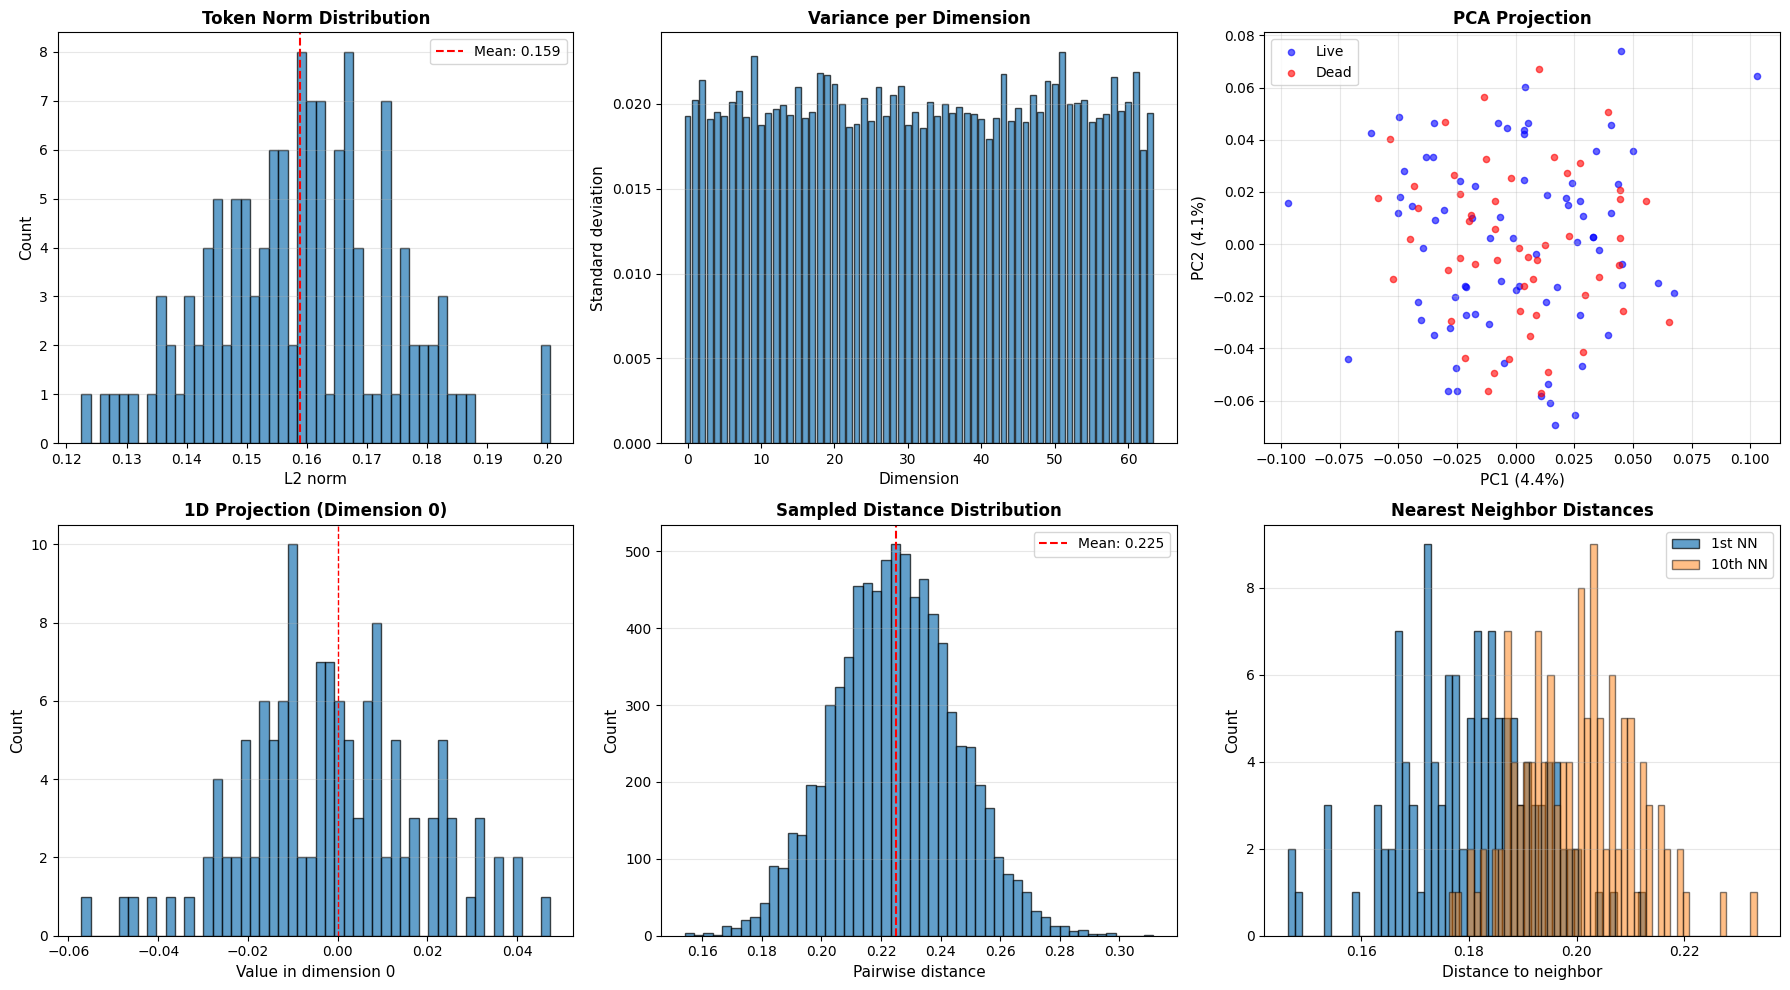

✓ Visualizations complete


In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=100)

# Plot 1: Norm distribution
ax = axes[0, 0]
ax.hist(norms.numpy(), bins=50, edgecolor='black', alpha=0.7)
ax.axvline(norms.mean().item(), color='red', linestyle='--', label=f'Mean: {norms.mean().item():.3f}')
ax.set_xlabel('L2 norm', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Token Norm Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Per-dimension standard deviation
ax = axes[0, 1]
ax.bar(range(n_dims), stds.numpy(), edgecolor='black', alpha=0.7)
ax.set_xlabel('Dimension', fontsize=11)
ax.set_ylabel('Standard deviation', fontsize=11)
ax.set_title('Variance per Dimension', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 3: PCA (PC1 vs PC2)
ax = axes[0, 2]
if has_masks:
    ax.scatter(W_pca[live_tokens, 0], W_pca[live_tokens, 1], alpha=0.6, s=20, label='Live', color='blue')
    ax.scatter(W_pca[dead_tokens, 0], W_pca[dead_tokens, 1], alpha=0.6, s=20, label='Dead', color='red')
    ax.legend()
else:
    ax.scatter(W_pca[:, 0], W_pca[:, 1], alpha=0.6, s=20, color='blue')
ax.set_xlabel(f'PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)', fontsize=11)
ax.set_title('PCA Projection', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Plot 4: 1D projection (dimension 0)
ax = axes[1, 0]
ax.hist(values_dim0.numpy(), bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel(f'Value in dimension {dim_to_test}', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title(f'1D Projection (Dimension {dim_to_test})', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 5: Distance distribution
ax = axes[1, 1]
ax.hist(distances.numpy(), bins=50, edgecolor='black', alpha=0.7)
ax.axvline(distances.mean().item(), color='red', linestyle='--', label=f'Mean: {distances.mean().item():.3f}')
ax.set_xlabel('Pairwise distance', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Sampled Distance Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 6: Nearest neighbor distances
ax = axes[1, 2]
ax.hist(nn_1st.numpy(), bins=50, edgecolor='black', alpha=0.7, label='1st NN')
ax.hist(nn_kth.numpy(), bins=50, edgecolor='black', alpha=0.5, label=f'{K_NEAREST_NEIGHBORS}th NN')
ax.set_xlabel('Distance to neighbor', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Nearest Neighbor Distances', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Summary

In [13]:
print("\n" + "=" * 80)
print("SUMMARY: CLOUD GEOMETRY")
print("=" * 80)
print()

print(f"Configuration:")
print(f"  Tokens: {n_vectors:,}")
print(f"  Dimensions: {n_dims:,}")
print()

print(f"Global structure:")
print(f"  Centroid norm: {centroid_norm:.6f}")
print(f"  Mean token norm: {norms.mean().item():.6f}")
print(f"  Mean pairwise distance: {distances.mean().item():.6f}")
print(f"  Top {N_PCA_COMPONENTS} PCs explain {100*cumulative_var:.1f}% variance")
print()

print(f"Local structure:")
print(f"  Mean 1st NN distance: {nn_1st.mean().item():.6f}")
print(f"  Mean {K_NEAREST_NEIGHBORS}th NN distance: {nn_kth.mean().item():.6f}")
print()

if has_masks:
    print(f"Live vs. Dead comparison:")
    print(f"  Norm difference: {(norms_live.mean() - norms_dead.mean()).item():.6f}")
    if p_value < 0.05:
        print(f"  ⚠️  Significantly different (p={p_value:.4f})")
    else:
        print(f"  ✓ No significant difference (p={p_value:.4f})")
    print()

print(f"Interpretation:")
if centroid_norm < 0.01:
    print(f"  • Cloud is well-centered at origin")
else:
    print(f"  • Cloud is offset from origin by {centroid_norm:.3f}")

if nn_kth.std() / nn_kth.mean() < 0.3:
    print(f"  • Uniform density (low variance in local neighborhoods)")
else:
    print(f"  • Non-uniform density (some regions denser than others)")

print()
print("Next steps:")
print("  → Run on W₀ to compare init vs. final")
print("  → Track evolution over training trajectory")
print("  → Compare to other models (e.g., Qwen)")

print("\n" + "=" * 80)


SUMMARY: CLOUD GEOMETRY

Configuration:
  Tokens: 128
  Dimensions: 64

Global structure:
  Centroid norm: 0.013697
  Mean token norm: 0.158937
  Mean pairwise distance: 0.224919
  Top 3 PCs explain 12.6% variance

Local structure:
  Mean 1st NN distance: 0.179968
  Mean 10th NN distance: 0.199729

Live vs. Dead comparison:
  Norm difference: -0.000329
  ✓ No significant difference (p=0.9160)

Interpretation:
  • Cloud is offset from origin by 0.014
  • Uniform density (low variance in local neighborhoods)

Next steps:
  → Run on W₀ to compare init vs. final
  → Track evolution over training trajectory
  → Compare to other models (e.g., Qwen)

